## **VISÃO COMPUTACIONAL - AULA 18**

**Objetivos da aula:**

*   apresentar o processo completo de visão estéreo
*   apresentar o conceito de disparidade e mapa de profundidade
*   praticar com reconstrução 3D

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

#### <b> CARGA DOS DADOS PARA RECONSTRUÇÃO 3D <b>


Esta sequencia de células é somente para descompactar o nosso arquivo de dados, formados pelas imagens e dados de calibração das câmeras. Em seguida, lemos os dados destes arquivos.



In [2]:
from zipfile import ZipFile
file_name = "data_road.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [3]:
data_folder_left = "data_road/training/image_2/"
data_folder_right = "data_road/training_right/image_3/"
data_folder_calib = "data_road/training/calib/"
cat = ['uu', 'uum', 'um']
IDX_LEN = 6

In [4]:
idx_num = 1
cat_idx = 2
fname = cat[cat_idx]+'_'+str(idx_num).zfill(IDX_LEN)
img_fname = fname + '.png'
calib_fname = fname + '.txt'

In [6]:
img_left_color = cv2.imread(data_folder_left + img_fname)
img_right_color = cv2.imread(data_folder_right + img_fname)

In [7]:
img_left_bw = cv2.blur(cv2.cvtColor(img_left_color, cv2.COLOR_RGB2GRAY),(5,5))
img_right_bw = cv2.blur(cv2.cvtColor(img_right_color, cv2.COLOR_RGB2GRAY),(5,5))

A imagem capturada pela câmera esquerda é mostrada abaixo:

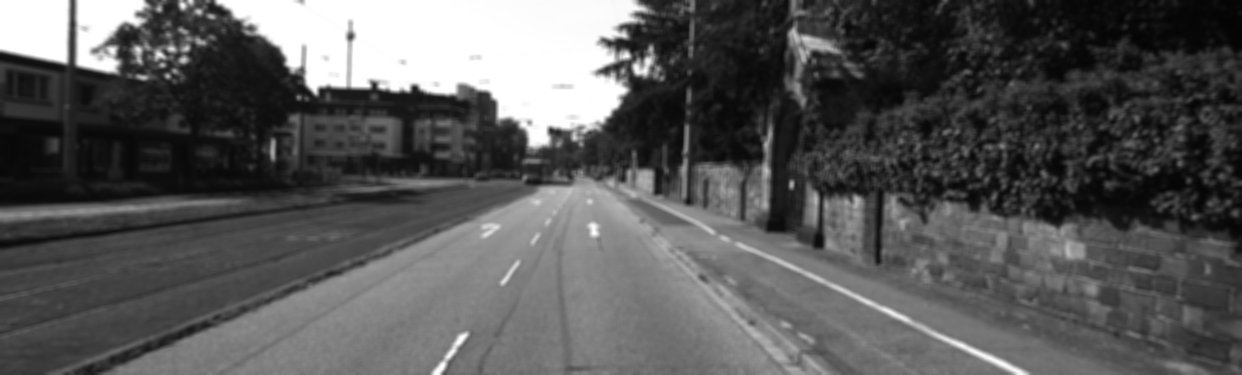

In [8]:
cv2_imshow(img_left_bw)

A imagem capturada pela câmera direita é mostrada abaixo:

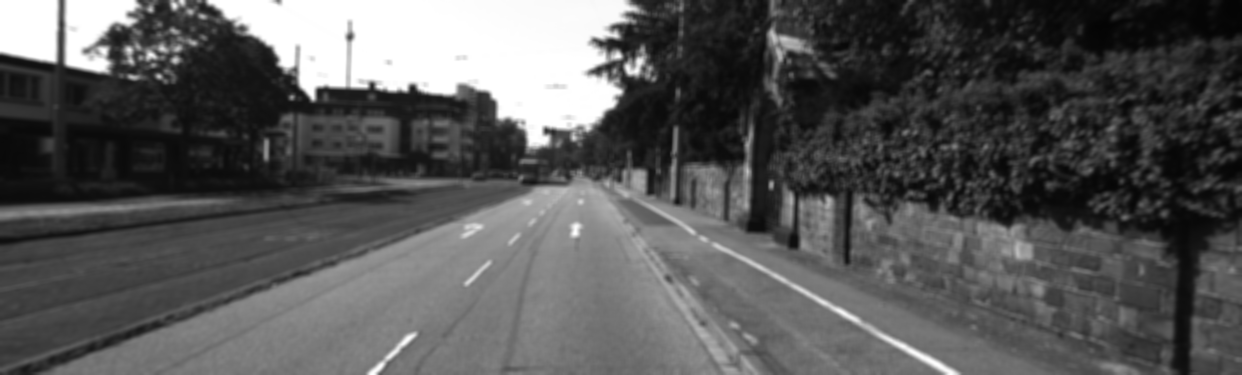

In [9]:
cv2_imshow(img_right_bw)

Abaixo, temos a leitura dos dados de calibração das câmeras:

In [10]:

matrix_type_1 = 'P2'
matrix_type_2 = 'P3'

calib_file = data_folder_calib + calib_fname
with open(calib_file, 'r') as f:
    fin = f.readlines()
    for line in fin:
        if line[:2] == matrix_type_1:
            calib_matrix_1 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
        elif line[:2] == matrix_type_2:
            calib_matrix_2 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)


In [11]:
calib_matrix_1

array([[7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
       [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
       [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]],
      dtype=float32)

In [12]:
calib_matrix_2

array([[ 7.215377e+02,  0.000000e+00,  6.095593e+02, -3.395242e+02],
       [ 0.000000e+00,  7.215377e+02,  1.728540e+02,  2.199936e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  2.729905e-03]],
      dtype=float32)

#### <b> CÁLCULO DE DISPARIDADES </b>

A disparidade é qualquer mudança entre a posição de objetos
no par de imagens, e é inversamente proporcional à distância do
objeto até a lente da câmera. Portanto a distância pode ser
calculada obtendo a disparidade de um par estéreo, e a disparidade
pode ser estimada através da correspondência dos objetos nas
imagens.

A OpenCV disponibiliza uma implementação do Algoritmo de Emparelhamento de Blocos (Bock Matching Algorithm). 

Referência: https://en.wikipedia.org/wiki/Block-matching_algorithm



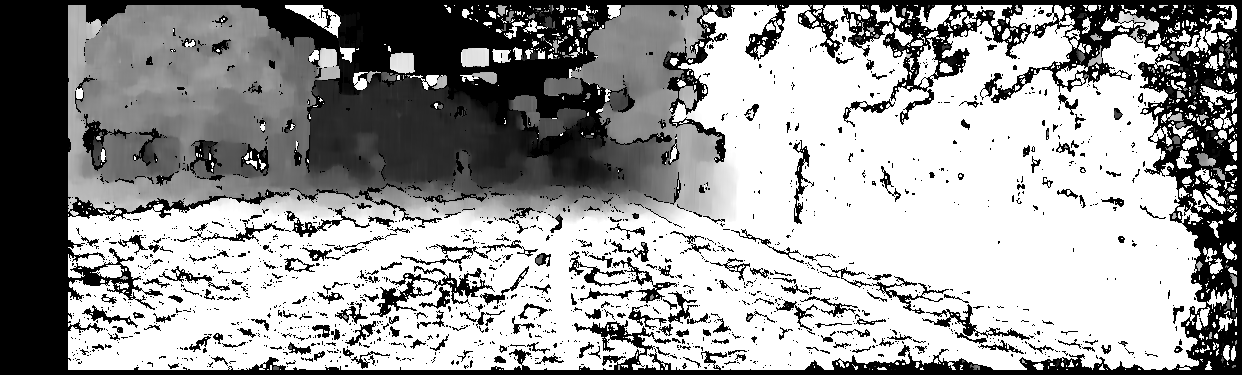

In [24]:
stereo = cv2.StereoBM_create(numDisparities=96, blockSize=11)
disparity = stereo.compute(img_left_bw,img_right_bw)
img = disparity.copy()
cv2_imshow(img)

#### <b>EXERCÍCIO</b>

Um dos parâmetros de configuração para cálculo de disparidades é o numDisparities. O que este parâmetro controla ? Por que ele precisa ser múltiplo de 16 ?

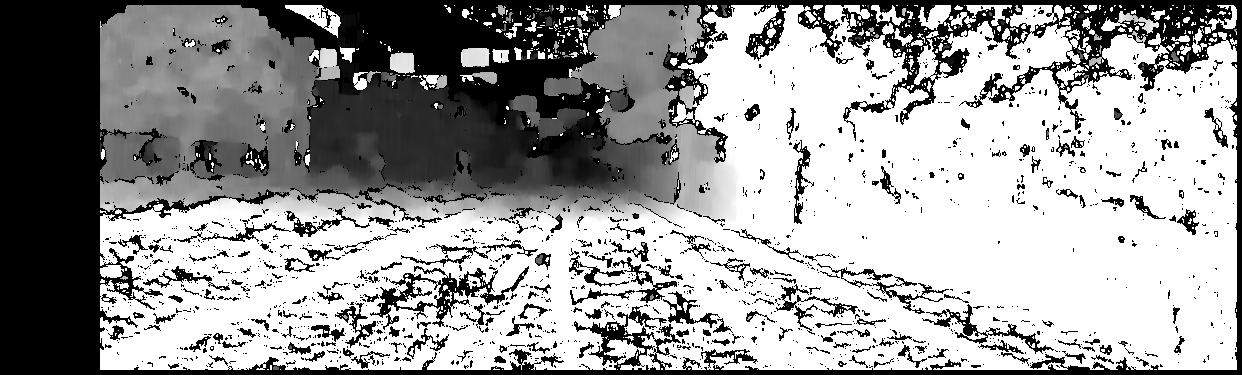

In [34]:
#controla o número de vizinhos na busca
stereo = cv2.StereoBM_create(numDisparities=96, blockSize=11)
disparity = stereo.compute(img_left_bw,img_right_bw)
img = disparity.copy()
cv2_imshow(img)

#### <b>EXERCÍCIO</b>

O segundo parâmetro é o blockSize... o que controla a configuração deste parâmetro ?

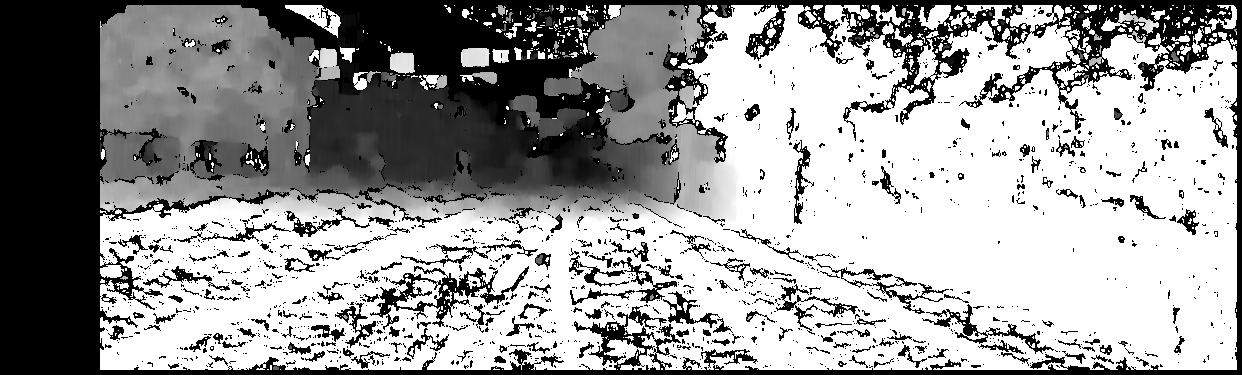

In [35]:
stereo = cv2.StereoBM_create(numDisparities=96, blockSize=11)
disparity = stereo.compute(img_left_bw,img_right_bw)
img = disparity.copy()
cv2_imshow(img)

#### <b> RECONSTRUÇÃO 3D </b>

A partir do mapa de disparidades, podemos obter a profundidade de cada ponto do par estéreo. Isto gera o chamado mapa de profundidade. 

<img src="https://www.researchgate.net/profile/Sing_Bing_Kang/publication/2313285/figure/fig1/AS:341573188505604@1458448802555/Relationship-between-the-baseline-b-disparity-d-focal-length-f-and-depth-z_W640.jpg"> </img>

Isto é feito pela função stereoRectify da OpenCV.

In [36]:
# Calculate depth-to-disparity
cam1 = calib_matrix_1[:,:3] # left image - P2
cam2 = calib_matrix_2[:,:3] # right image - P3

Tmat = np.array([0.54, 0., 0.])

rev_proj_matrix = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                  distCoeffs1 = 0, distCoeffs2 = 0, \
                  imageSize = img_left_color.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = rev_proj_matrix);


O resultado principal da stereoRectify é determinar a matriz inversa de projeção de uma das câmeras do setup de visão estéreo. Uma vez que tenhamos esta matriz, podemos reconstruir a estrutura 3D de qualquer objeto. 

In [37]:
points = cv2.reprojectImageTo3D(img, rev_proj_matrix)

#reflect on x axis
reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points,reflect_matrix)

#extract colors from image
colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = img > img.min()
out_points = points[mask]
out_colors = colors[mask]

#filter by dimension
idx = np.fabs(out_points[:,0]) < 4.5
out_points = out_points[idx]
out_colors = out_colors.reshape(-1, 3)
out_colors = out_colors[idx]

print("Pontos Reconstruídos:")
print(points[0])


Pontos Reconstruídos:
[[ 20.57262802  -5.83382273  24.35189819]
 [ 20.53887749  -5.83382273  24.35189819]
 [ 20.50512695  -5.83382273  24.35189819]
 ...
 [-21.24362183  -5.83382273  24.35189819]
 [-21.27737236  -5.83382273  24.35189819]
 [-21.31112289  -5.83382273  24.35189819]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in matmul
  


#### <b> ARMAZENAMENTO DA NUVEM DE PONTOS </b>

A nuvem de pontos reconstruída anteriormente, pode ser armazenada de diversas maneiras. Uma das maneiras comuns é salvar os resultado no formato PLY.

Referência: https://en.wikipedia.org/wiki/PLY_(file_format)

In [38]:
def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

write_ply('out.ply', out_points, out_colors)
print('%s saved' % 'out.ply')

out.ply saved


#### <b> VERIFICAÇÃO DOS PONTOS PROJETADOS </b>

Uma vez que tenhamos reconstruídos os pontos, podemos verificar a qualidade da reconstruída, reprojetando os pontos reconstruídos para produzir uma nova imgame.

In [16]:
reflected_pts = np.matmul(out_points, reflect_matrix)
projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                          cam2[:3,:3], np.array([0., 0., 0., 0.]))
projected_img = projected_img.reshape(-1, 2)

In [17]:
blank_img = np.zeros(img_left_color.shape, 'uint8')
img_colors = img_right_color[mask][idx].reshape(-1,3)

for i, pt in enumerate(projected_img):
    pt_x = int(pt[0])
    pt_y = int(pt[1])
    if pt_x > 0 and pt_y > 0:
        # use the BGR format to match the original image type
        col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
        cv2.circle(blank_img, (pt_x, pt_y), 1, col)

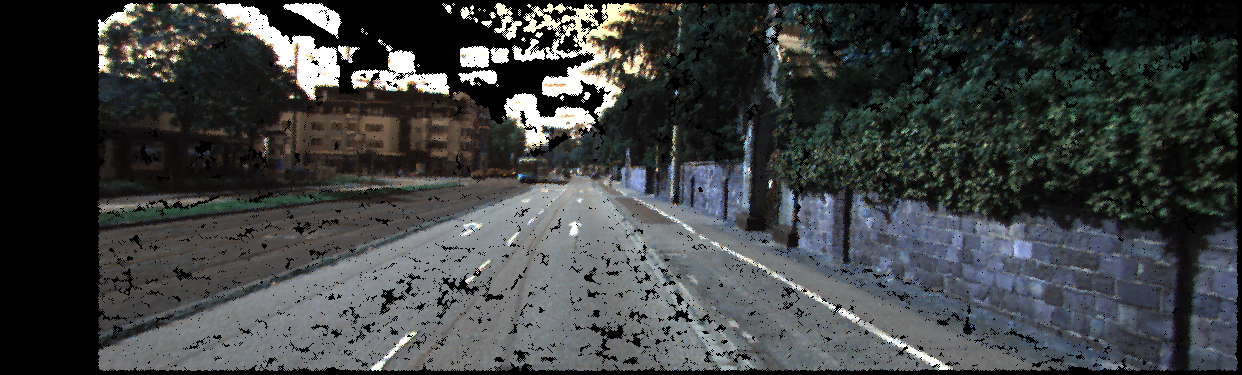

In [18]:
cv2_imshow(blank_img)

#### <b>EXERCÍCIO</b>

Como a geração do mapa de disparidades controla a qualidade dos pontos reconstruídos ? Faça experimentos para verificar como a qualidade do mapa de disparidades controla a qualidade da reconstrução.

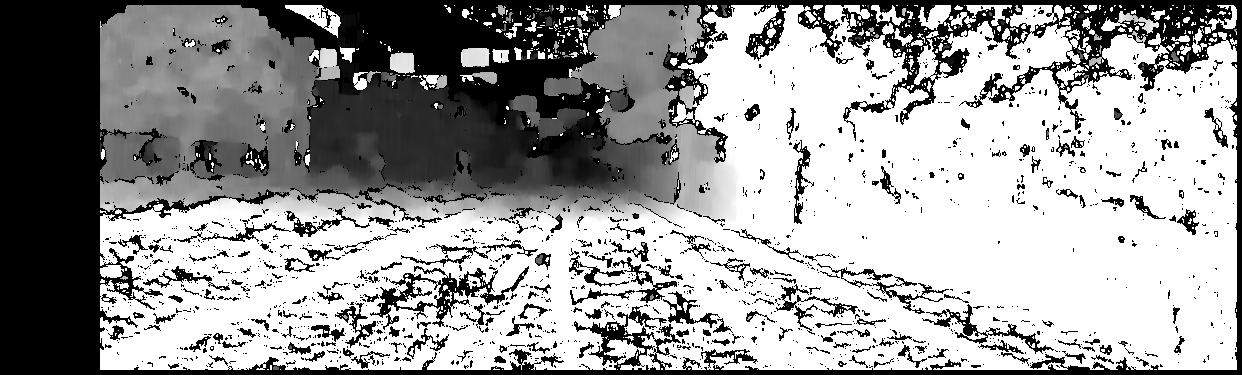

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in matmul


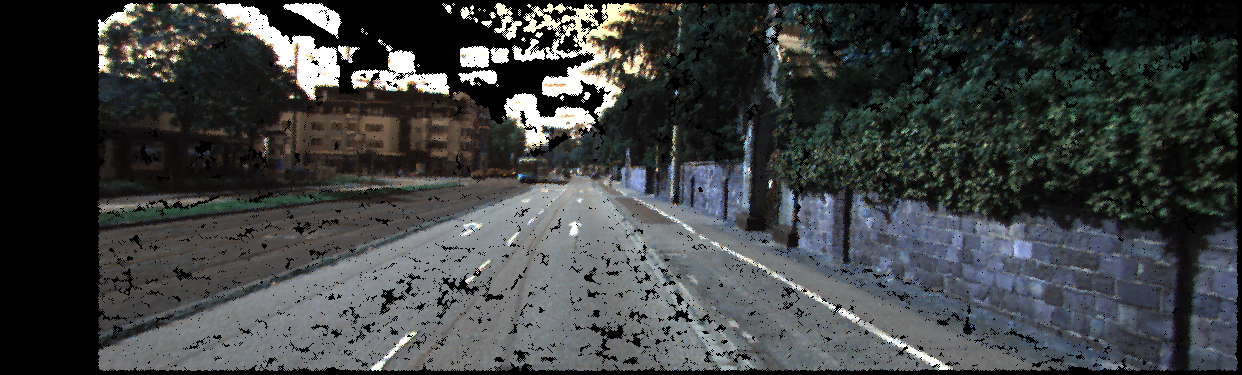

In [48]:
stereo = cv2.StereoBM_create(numDisparities=96, blockSize=11)
disparity = stereo.compute(img_left_bw,img_right_bw)
img = disparity.copy()
cv2_imshow(img)

# Calculate depth-to-disparity
cam1 = calib_matrix_1[:,:3] # left image - P2
cam2 = calib_matrix_2[:,:3] # right image - P3

Tmat = np.array([0.54, 0., 0.])

rev_proj_matrix = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                  distCoeffs1 = 0, distCoeffs2 = 0, \
                  imageSize = img_left_color.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = rev_proj_matrix);

points = cv2.reprojectImageTo3D(img, rev_proj_matrix)

#reflect on x axis
reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points,reflect_matrix)

#extract colors from image
colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = img > img.min()
out_points = points[mask]
out_colors = colors[mask]

#filter by dimension
idx = np.fabs(out_points[:,0]) < 4.5
out_points = out_points[idx]
out_colors = out_colors.reshape(-1, 3)
out_colors = out_colors[idx]


reflected_pts = np.matmul(out_points, reflect_matrix)
projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                          cam2[:3,:3], np.array([0., 0., 0., 0.]))
projected_img = projected_img.reshape(-1, 2)

blank_img = np.zeros(img_left_color.shape, 'uint8')
img_colors = img_right_color[mask][idx].reshape(-1,3)

for i, pt in enumerate(projected_img):
    pt_x = int(pt[0])
    pt_y = int(pt[1])
    if pt_x > 0 and pt_y > 0:
        # use the BGR format to match the original image type
        col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
        cv2.circle(blank_img, (pt_x, pt_y), 1, col)

cv2_imshow(blank_img)